# Bootstrap analysis of all task's  weights

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
import seaborn as sns

In [3]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [6]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno'
mask_path = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/mask_roi_resample.nii.gz'

## 1 - Clustering by subjects

In [1]:
df_stack = pd.read_csv(os.path.join(path_root,'all_subtypes_weights_stack.csv'))
df_stack = df_stack.set_index('IDs').T.reset_index(drop=True)

NameError: name 'pd' is not defined

In [20]:
df_stack = df_stack.ix[:,0:]
df_stack.describe()

IDs,HCP100307,HCP100408,HCP100610,HCP101006,HCP101309,HCP101410,HCP101915,HCP102008,HCP102311,HCP102513,...,HCP983773,HCP984472,HCP987983,HCP990366,HCP991267,HCP992673,HCP992774,HCP993675,HCP994273,HCP996782
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,...,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,-0.157904,0.100372,-0.029121,-0.025811,0.005546,0.020688,-0.029634,0.010150,0.040479,0.057730,...,-0.024356,0.114769,-0.103092,-0.087003,-0.054631,0.011266,0.096885,-0.047045,0.026198,-0.032325
std,1.651872,1.296017,1.069787,0.939944,0.737242,0.855242,0.930594,0.774541,0.852958,0.756429,...,0.898234,1.050458,1.025301,0.934469,0.826922,0.925473,1.355410,0.851946,0.805965,1.073506
min,-2.830840,-2.230989,-2.513090,-2.177621,-1.773175,-1.892283,-1.907390,-2.136583,-2.450174,-1.705686,...,-1.851702,-2.032514,-2.440324,-2.162341,-2.161481,-2.103567,-2.691903,-1.978015,-1.641643,-2.115315
25%,-1.863354,-1.113131,-0.712756,-0.811680,-0.504747,-0.564141,-0.659670,-0.566444,-0.543483,-0.410235,...,-0.784510,-0.723331,-0.857830,-0.811879,-0.678020,-0.678489,-0.909835,-0.668361,-0.572775,-1.007808
50%,-0.303848,-0.104215,-0.067463,-0.061098,0.063609,0.033803,0.018809,0.000480,-0.001074,-0.012314,...,-0.107548,0.186744,-0.211238,-0.245598,-0.023909,0.043695,0.141995,-0.111482,0.013063,-0.072357
75%,1.456212,1.293282,0.835466,0.653062,0.455046,0.607419,0.531047,0.613787,0.695834,0.536189,...,0.633263,0.982460,0.627060,0.619189,0.504993,0.689495,1.224041,0.593327,0.681296,0.904584
max,2.581144,2.242397,2.236352,2.266941,1.678551,2.103670,1.919685,1.643692,2.674251,1.797511,...,2.443770,2.348139,2.216010,2.168028,2.158215,2.179594,2.636485,2.602567,1.740590,1.904161


In [21]:
# extract all table value
y = df_stack.loc[:].values
LABELS_Y = list(df_stack.columns.values)

In [25]:
# push it to octave
%octave_push y
y.shape

(115, 713)

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

ans =  1

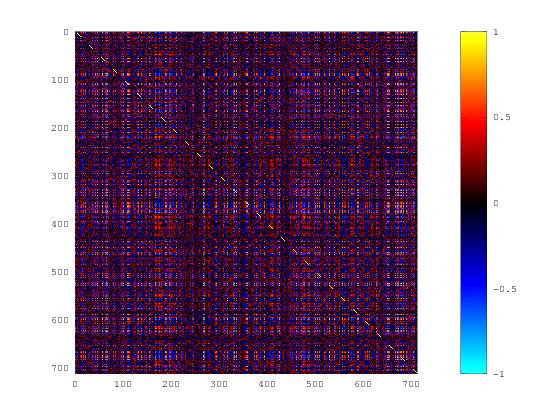

In [26]:
%%octave
nb_cluster =7;   # numb of clusters 
R = corr(y);
title('Spatial correlation matrix')
niak_visu_matrix(R), axis square

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 Done ! 

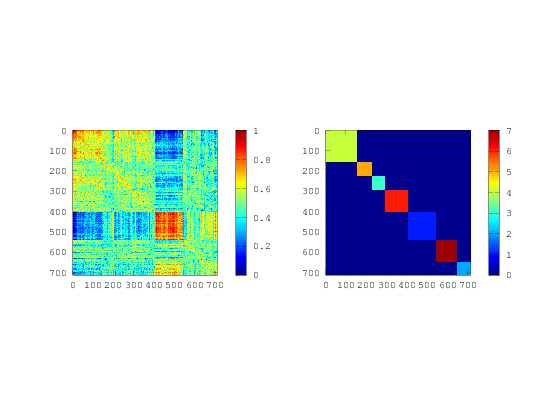

In [27]:
%%octave
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

If the clustering had done a perfect job, we would have squares on the diagonal.

In [28]:
#%octave niak_visu_dendrogram(hier)

## boostrap analysis of stable clusters
 

In [29]:
%%octave
nb_samp = 100;
opt_b.block_length = 1; # That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); # Bootstrap the subjects
    R_s = corr(y_s); # compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); # replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); # Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); # convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; # Add all adjacency matrices
end
stab = stab / nb_samp; # Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100

Let's have a look at the stability matrix:

In [30]:
%%octave -o nb_cluster
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy

     Percentage done : 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 Done ! 

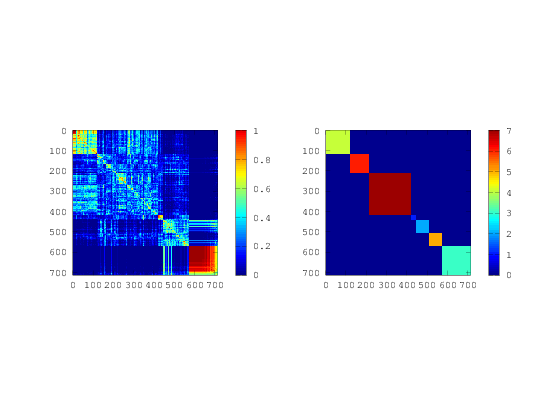

In [31]:
%%octave
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered consensus matrix')
imagesc(stab(order_consensus,order_consensus)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part_consensus(order_consensus)), axis square

In [32]:
#%octave niak_visu_dendrogram(hier_consensus)

ans =  1

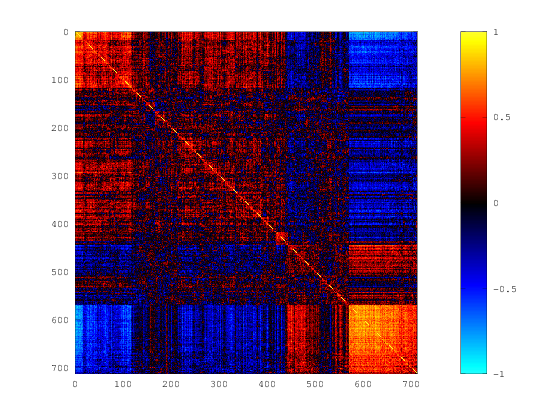

In [33]:
%%octave
# Re-order the correlation matrix
title('re-ordered correlation matrix')
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar

In [34]:
# push labels to octave
%octave_push LABELS_Y
%octave LABELS_Y = LABELS_Y';

In [35]:
%%octave
# calculate the mean cluster and save it
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
order_s =[];
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end

Cluster 1: 

     HCP100610 

     HCP202113 

     HCP353740 

     HCP381543 

     HCP568963 

     HCP117930 

     HCP594156 

     HCP856968 

     HCP352132 

     HCP687163 

     HCP158338 

     HCP996782 

     HCP188751 

     HCP548250 

     HCP456346 

     HCP668361 

     HCP524135 

     HCP919966 

     HCP118528 

     HCP749058 

     HCP208327 

     HCP837560 

     HCP157942 

     HCP523032 

     HCP894067 

     HCP978578 

Cluster 2: 

     HCP101309 

     HCP103515 

     HCP126325 

     HCP168139 

     HCP108525 

     HCP150524 

     HCP134324 

     HCP748258 

     HCP115219 

     HCP145127 

     HCP585256 

     HCP144125 

     HCP378857 

     HCP103111 

     HCP111312 

     HCP130013 

     HCP210617 

     HCP121618 

     HCP499566 

     HCP146432 

     HCP168341 

     HCP965367 

     HCP192136 

     HCP587664 

     HCP322224 

     HCP361941 

     HCP149741 

     HCP994273 

     HCP748662 

     HCP814649 

     HCP849971 

     HCP912447 

     HCP441939 

     HCP473952 

     HCP540436 

     HCP163836 

     HCP211922 

     HCP381038 

     HCP878776 

     HCP212217 

     HCP333330 

     HCP386250 

     HCP212419 

     HCP843151 

     HCP107321 

     HCP108828 

     HCP742549 

     HCP175035 

     HCP555348 

     HCP134728 

     HCP192035 

     HCP818859 

     HCP177241 

     HCP172029 

     HCP285345 

     HCP250932 

     HCP211720 

     HCP436239 

     HCP406432 

     HCP958976 

     HCP211316 

     HCP320826 

     HCP433839 

     HCP833148 

Cluster 3: 

     HCP100408 

     HCP157336 

     HCP156637 

     HCP246133 

     HCP856766 

     HCP598568 

     HCP118730 

     HCP414229 

     HCP172332 

     HCP214423 

     HCP732243 

     HCP133625 

     HCP149539 

     HCP160123 

     HCP704238 

     HCP889579 

     HCP127933 

     HCP293748 

     HCP201111 

     HCP677968 

     HCP174437 

     HCP894673 

     HCP680957 

     HCP307127 

     HCP366446 

     HCP151526 

     HCP221319 

     HCP217429 

     HCP200614 

     HCP702133 

     HCP209935 

     HCP705341 

     HCP117324 

     HCP857263 

     HCP176542 

     HCP371843 

     HCP992774 

     HCP120212 

     HCP143325 

     HCP163432 

     HCP162329 

     HCP133827 

     HCP351938 

     HCP729557 

     HCP788876 

     HCP904044 

     HCP129028 

     HCP865363 

     HCP581349 

     HCP917255 

     HCP205826 

     HCP665254 

     HCP887373 

     HCP130922 

     HCP214221 

     HCP579665 

     HCP959574 

     HCP627549 

     HCP390645 

     HCP149337 

     HCP194140 

     HCP133928 

     HCP182739 

     HCP208226 

     HCP239944 

     HCP113215 

     HCP128632 

     HCP212318 

     HCP158540 

     HCP761957 

     HCP103414 

     HCP753251 

     HCP142828 

     HCP298051 

     HCP570243 

     HCP139637 

     HCP871964 

     HCP899885 

     HCP148032 

     HCP255639 

     HCP110411 

     HCP586460 

     HCP250427 

     HCP136833 

     HCP932554 

     HCP199150 

     HCP114419 

     HCP896879 

     HCP137128 

     HCP552544 

     HCP530635 

     HCP541943 

     HCP429040 

     HCP118932 

     HCP105216 

     HCP561242 

     HCP193239 

     HCP885975 

     HCP151223 

     HCP901139 

     HCP497865 

     HCP106319 

     HCP197550 

     HCP214019 

     HCP175439 

     HCP103818 

     HCP153429 

     HCP984472 

     HCP161731 

     HCP138534 

     HCP190031 

     HCP448347 

     HCP154431 

     HCP159946 

     HCP224022 

     HCP826353 

     HCP645551 

     HCP111009 

     HCP861456 

     HCP117122 

     HCP158035 

     HCP644044 

     HCP196144 

     HCP245333 

     HCP135932 

     HCP105115 

     HCP638049 

     HCP115320 

     HCP131924 

     HCP397760 

     HCP802844 

     HCP199655 

     HCP559053 

     HCP124422 

     HCP751348 

     HCP387959 

     HCP192540 

     HCP395756 

     HCP211417 

     HCP859671 

     HCP136227 

     HCP922854 

     HCP599671 

Cluster 4: 

     HCP100307 

     HCP138231 

     HCP792564 

     HCP205725 

     HCP249947 

     HCP119833 

     HCP159239 

     HCP724446 

     HCP151627 

     HCP167743 

     HCP896778 

     HCP150423 

     HCP773257 

     HCP185139 

     HCP257542 

     HCP154229 

     HCP205220 

     HCP104820 

     HCP525541 

     HCP529953 

     HCP169444 

     HCP189349 

     HCP179346 

     HCP492754 

     HCP114318 

     HCP767464 

     HCP148840 

     HCP187345 

     HCP188448 

     HCP175237 

     HCP683256 

     HCP114621 

     HCP268749 

     HCP167036 

     HCP506234 

     HCP137633 

     HCP520228 

     HCP613538 

     HCP348545 

     HCP679770 

     HCP422632 

     HCP617748 

     HCP633847 

     HCP990366 

     HCP130417 

     HCP160729 

     HCP562446 

     HCP151829 

     HCP852455 

     HCP735148 

     HCP952863 

     HCP162935 

     HCP555651 

     HCP209127 

     HCP679568 

     HCP129937 

     HCP187547 

     HCP183034 

     HCP445543 

     HCP316633 

     HCP529549 

     HCP573249 

     HCP856463 

     HCP656253 

     HCP803240 

     HCP171330 

     HCP204420 

     HCP209329 

     HCP475855 

     HCP877269 

     HCP195445 

     HCP923755 

     HCP159340 

     HCP812746 

     HCP907656 

     HCP164636 

     HCP188347 

     HCP583858 

     HCP173940 

     HCP601127 

     HCP299154 

     HCP573451 

     HCP108323 

     HCP114217 

     HCP751550 

     HCP571144 

     HCP841349 

     HCP891667 

     HCP118023 

     HCP200008 

     HCP599065 

     HCP784565 

     HCP122620 

     HCP148133 

     HCP987983 

     HCP957974 

     HCP228434 

     HCP616645 

     HCP124624 

     HCP150726 

     HCP580751 

     HCP979984 

     HCP771354 

     HCP162026 

     HCP180432 

     HCP677766 

     HCP210011 

     HCP317332 

     HCP793465 

     HCP112920 

     HCP192439 

     HCP580044 

     HCP153631 

     HCP212823 

     HCP275645 

     HCP467351 

     HCP671855 

     HCP211215 

Cluster 5: 

     HCP102513 

     HCP154936 

     HCP170934 

     HCP105014 

     HCP141119 

     HCP308129 

     HCP123420 

     HCP158136 

     HCP657659 

     HCP127630 

     HCP833249 

     HCP481951 

     HCP135225 

     HCP561444 

     HCP153025 

     HCP628248 

     HCP737960 

     HCP106521 

     HCP148335 

     HCP180129 

     HCP645450 

     HCP176441 

     HCP835657 

     HCP194746 

     HCP178142 

     HCP212116 

     HCP116524 

     HCP627852 

     HCP185947 

     HCP134829 

     HCP189450 

     HCP173334 

     HCP377451 

     HCP626648 

     HCP140824 

     HCP449753 

     HCP572045 

     HCP112112 

     HCP415837 

     HCP120111 

     HCP585862 

     HCP951457 

     HCP749361 

     HCP209834 

     HCP251833 

     HCP116221 

     HCP128935 

     HCP122317 

     HCP820745 

     HCP168745 

     HCP395958 

     HCP156536 

     HCP623844 

     HCP212015 

     HCP121416 

     HCP204016 

     HCP131217 

     HCP898176 

     HCP759869 

     HCP129129 

     HCP202719 

     HCP166438 

Cluster 6: 

     HCP101006 

     HCP186141 

     HCP172433 

     HCP195041 

     HCP303624 

     HCP536647 

     HCP769064 

     HCP654350 

     HCP155938 

     HCP199453 

     HCP208125 

     HCP223929 

     HCP991267 

     HCP385450 

     HCP346137 

     HCP125525 

     HCP672756 

     HCP163331 

     HCP329440 

     HCP545345 

     HCP179548 

     HCP268850 

     HCP355239 

     HCP379657 

     HCP187850 

     HCP412528 

     HCP663755 

     HCP316835 

     HCP566454 

     HCP101410 

     HCP310621 

     HCP753150 

     HCP531536 

     HCP604537 

     HCP102311 

     HCP198855 

     HCP204521 

     HCP124220 

     HCP127327 

     HCP194645 

     HCP693764 

     HCP196346 

     HCP992673 

     HCP159138 

     HCP195950 

     HCP178950 

     HCP198350 

     HCP227432 

     HCP105620 

     HCP145834 

     HCP257845 

     HCP148436 

     HCP177645 

     HCP826454 

     HCP106016 

     HCP151425 

     HCP318637 

     HCP208024 

     HCP406836 

     HCP139839 

     HCP164030 

     HCP358144 

     HCP135730 

     HCP993675 

     HCP186444 

     HCP174841 

     HCP192843 

     HCP356948 

     HCP622236 

     HCP116726 

     HCP647858 

     HCP210415 

     HCP700634 

     HCP150625 

     HCP436845 

     HCP715041 

     HCP144832 

     HCP280739 

     HCP172938 

     HCP479762 

     HCP782561 

     HCP580650 

     HCP129634 

     HCP201414 

     HCP789373 

     HCP173839 

     HCP217126 

     HCP880157 

     HCP308331 

     HCP510326 

     HCP942658 

     HCP620434 

     HCP882161 

Cluster 7: 

     HCP101915 

     HCP983773 

     HCP170631 

     HCP107018 

     HCP237334 

     HCP191942 

     HCP107422 

     HCP567961 

     HCP300618 

     HCP113922 

     HCP191033 

     HCP161630 

     HCP341834 

     HCP395251 

     HCP519950 

     HCP200311 

     HCP201818 

     HCP588565 

     HCP104416 

     HCP175742 

     HCP130316 

     HCP134425 

     HCP686969 

     HCP173536 

     HCP709551 

     HCP130619 

     HCP339847 

     HCP972566 

     HCP581450 

     HCP156435 

     HCP181131 

     HCP453441 

     HCP131722 

     HCP366042 

     HCP486759 

     HCP690152 

     HCP382242 

     HCP567052 

     HCP393550 

     HCP579867 

     HCP731140 

     HCP109325 

     HCP166640 

     HCP871762 

     HCP134021 

     HCP901442 

     HCP148941 

     HCP194847 

     HCP966975 

     HCP122822 

     HCP163129 

     HCP137936 

     HCP695768 

     HCP176037 

     HCP298455 

     HCP336841 

     HCP707749 

     HCP102008 

     HCP204622 

     HCP592455 

     HCP120515 

     HCP844961 

     HCP173738 

     HCP465852 

     HCP141826 

     HCP181232 

     HCP303119 

     HCP618952 

     HCP112516 

     HCP135528 

     HCP153833 

     HCP286650 

     HCP131419 

     HCP160931 

     HCP108121 

     HCP203418 

     HCP139233 

     HCP199958 

     HCP285446 

     HCP118124 

     HCP185341 

     HCP248339 

     HCP459453 

     HCP870861 

     HCP110007 

     HCP214726 

     HCP132017 

     HCP195849 

     HCP128127 

     HCP263436 

     HCP305830 

     HCP309636 

     HCP150928 

     HCP185442 

     HCP164131 

     HCP910241 

     HCP517239 

     HCP178849 

     HCP256540 

     HCP867468 

     HCP114823 

     HCP872562 

     HCP140117 

     HCP156031 

     HCP151728 

     HCP176239 

     HCP191336 

     HCP667056 

     HCP129331 

     HCP680250 

     HCP330324 

     HCP352738 

     HCP137027 

     HCP321323 

     HCP233326 

     HCP845458 

     HCP955465 

     HCP175338 

     HCP214524 

     HCP207426 

     HCP220721 

     HCP792867 

     HCP111413 

     HCP334635 

     HCP167238 

     HCP283543 

     HCP204319 

     HCP522434 

     HCP155635 

     HCP172534 

     HCP673455 

     HCP162733 

     HCP346945 

     HCP180937 

     HCP131823 

     HCP816653 

     HCP198249 

     HCP609143 

     HCP120717 

     HCP389357 

     HCP169747 

     HCP124826 

     HCP154734 

     HCP154532 

     HCP547046 

     HCP599469 

     HCP126628 

     HCP800941 

     HCP770352 

     HCP894774 

     HCP134223 

     HCP930449 

     HCP191841 

     HCP720337 

     HCP155231 

     HCP397861 

     HCP500222 

     HCP513736 

     HCP173435 

     HCP200109 

     HCP111716 

     HCP917558 

     HCP147737 

     HCP119732 

     HCP149236 

     HCP137229 

     HCP361234 

     HCP231928 

     HCP152831 

     HCP150019 

     HCP597869 

     HCP380036 

     HCP872764 

     HCP149842 

     HCP744553 

     HCP154835 

     HCP108222 

     HCP158843 

     HCP424939 

     HCP165638 

     HCP133019 

     HCP365343 

     HCP118225 

     HCP615744 

     HCP141422 

     HCP926862 

     HCP115017 

     HCP290136 

     HCP146937 

     HCP198653 

     HCP432332 

     HCP304727 

     HCP779370 

     HCP109123 

     HCP180735 

     HCP495255 

     HCP121921 

     HCP187143 

     HCP792766 

     HCP123925 

     HCP179245 

     HCP727553 

     HCP173233 

     HCP180836 

     HCP209228 

     HCP397154 

     HCP837964 

## 2 - Clustering by Weights

In [39]:
df_stack = pd.read_csv(os.path.join(path_root,'all_subtypes_weights_stack.csv'))

In [40]:
# extract maps for volume figures
df_stack_maps = pd.read_csv(os.path.join(path_root,'all_subtype_stack.csv'))
y_maps = df_stack_maps.loc[:].values
%octave_push y_maps

In [41]:
df_stack = df_stack.ix[:,1:]
df_stack.describe()

,sub1_fear,sub2_fear,sub3_fear,sub4_fear,sub5_fear,sub1_win,sub2_win,sub3_win,sub4_win,sub5_win,...,sub1_tools,sub2_tools,sub3_tools,sub4_tools,sub5_tools,sub1_0bk,sub2_0bk,sub3_0bk,sub4_0bk,sub5_0bk
count,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,...,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02,7.130000e+02
mean,-3.238799e-17,-3.487938e-17,1.245692e-17,-4.235353e-17,-1.993107e-17,-6.228460e-18,1.743969e-17,8.719844e-18,9.965536e-18,-9.965536e-18,...,9.965536e-18,-2.989661e-17,-4.982768e-18,8.719844e-18,1.245692e-17,1.370261e-17,-7.474152e-18,1.494830e-17,-4.235353e-17,-2.989661e-17
std,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,...,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00,1.000702e+00
min,-2.311797e+00,-2.580094e+00,-2.442055e+00,-2.314590e+00,-2.569550e+00,-2.719801e+00,-2.479227e+00,-3.089519e+00,-2.488963e+00,-2.739767e+00,...,-2.383899e+00,-2.467726e+00,-2.670361e+00,-2.325630e+00,-2.830840e+00,-2.668454e+00,-2.680425e+00,-3.410516e+00,-2.792059e+00,-2.377475e+00
25%,-7.255770e-01,-7.349781e-01,-6.786096e-01,-7.671338e-01,-7.232689e-01,-6.966621e-01,-7.192504e-01,-6.647906e-01,-7.017363e-01,-7.061060e-01,...,-7.970350e-01,-7.014891e-01,-5.827931e-01,-7.423411e-01,-7.942533e-01,-6.748996e-01,-7.226516e-01,-6.652669e-01,-6.926422e-01,-7.034638e-01
50%,-1.963147e-01,-2.014635e-02,9.181886e-02,-1.223936e-01,7.061503e-02,-4.198846e-02,1.711029e-02,-1.670288e-02,-4.798445e-02,-2.405794e-02,...,-4.950348e-02,-1.186491e-01,9.577221e-02,-2.025726e-02,-5.843402e-02,-6.520614e-02,-1.497805e-03,-7.405926e-04,2.454542e-02,-8.238705e-02
75%,6.571875e-01,7.346405e-01,7.216397e-01,7.217663e-01,7.768184e-01,6.303516e-01,6.337793e-01,6.923123e-01,7.246801e-01,7.292410e-01,...,7.044881e-01,5.820597e-01,7.210545e-01,7.195810e-01,7.095095e-01,5.927182e-01,6.867559e-01,6.669998e-01,7.255249e-01,6.546284e-01
max,2.586655e+00,2.752444e+00,2.369146e+00,2.370889e+00,2.707422e+00,2.974857e+00,2.752147e+00,3.602807e+00,2.609848e+00,2.650130e+00,...,2.922742e+00,2.743507e+00,2.581144e+00,2.808275e+00,2.324145e+00,2.755405e+00,2.878555e+00,2.563851e+00,2.549247e+00,2.902881e+00


In [42]:
# extract all table value
y = df_stack.loc[:].values
LABELS_Y = list(df_stack.columns.values)
# push it to octave
%octave_push y
y.shape

(713, 115)

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

ans =  1

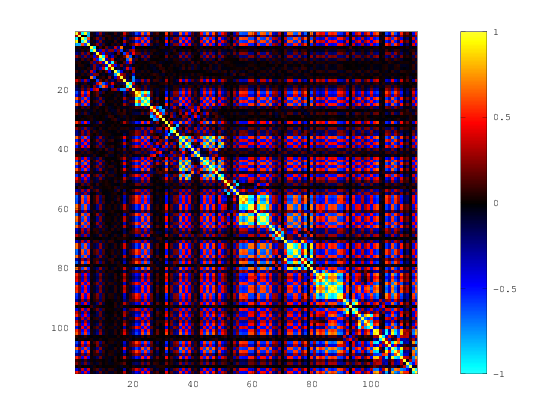

In [43]:
%%octave
nb_cluster =7;   # numb of clusters 
R = corr(y);
title('Spatial correlation matrix')
niak_visu_matrix(R), axis square

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 5 11 16 20 25 31 35 40 46 50 55 61 66 70 75 81 85 90 96 100 Done ! 

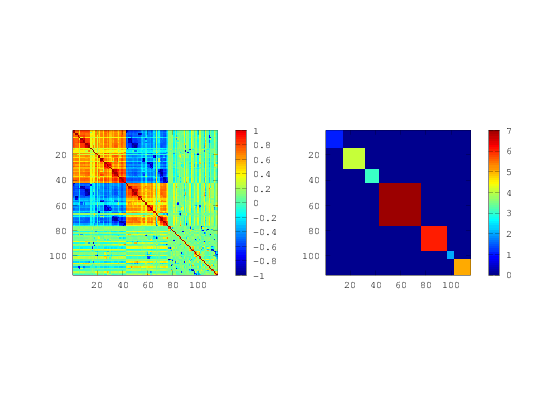

In [44]:
%%octave
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

If the clustering had done a perfect job, we would have squares on the diagonal.

In [45]:
#%octave niak_visu_dendrogram(hier)

## boostrap analysis of stable clusters
 

In [46]:
%%octave
nb_samp = 100;
opt_b.block_length = 1; # That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); # Bootstrap the subjects
    R_s = corr(y_s); # compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); # replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); # Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); # convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; # Add all adjacency matrices
end
stab = stab / nb_samp; # Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100

In [76]:
%%octave -i path_root -o stab_tmp
save( [path_root filesep 'stability_maps_weights_' date '.mat'],'stab')
stab_tmp = load([path_root filesep 'stability_maps_' date '.mat']);

In [77]:
%%octave
stab_m= (stab+stab_tmp.stab)/2;
size(stab_m)

ans =

   115   115

     Percentage done : 0 5 11 16 20 25 31 35 40 46 50 55 61 66 70 75 81 85 90 96 100 Done ! 

ans =  3

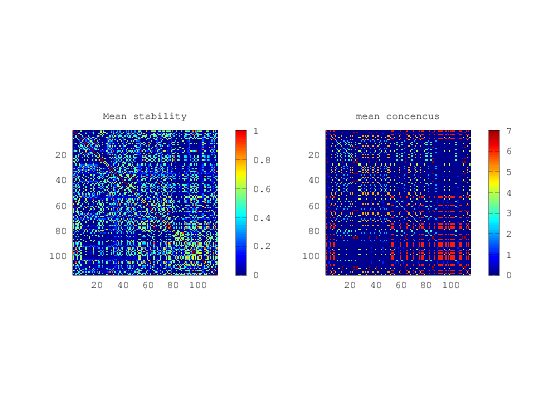

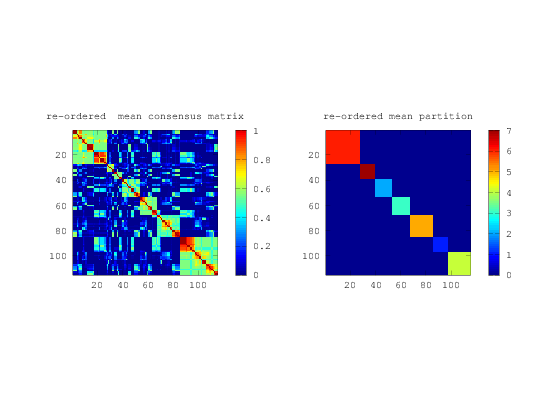

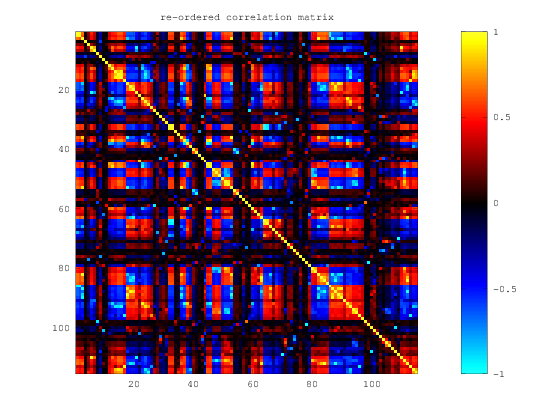

In [83]:
%%octave
subplot(1,2,1)
imagesc(stab_m), axis square, colormap(jet), colorbar, title('Mean stability')
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab_m); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy
subplot(1,2,2)
niak_visu_part(part_consensus), axis square, colormap(jet),title('mean concencus') # visualize the consensus partition
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
figure
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab_m(order_consensus,order_consensus)), axis square,colorbar, title('re-ordered  mean consensus matrix')
# Show the re-ordered partition
subplot(1,2,2)
niak_visu_part(part_consensus(order_consensus)), axis square,colorbar,title('re-ordered mean partition')
# Re-order the correlation matrix
figure
subplot(1,1,1)
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar,title('re-ordered correlation matrix')

     Percentage done : 0 5 11 16 20 25 31 35 40 46 50 55 61 66 70 75 81 85 90 96 100 Done ! 

ans =  3

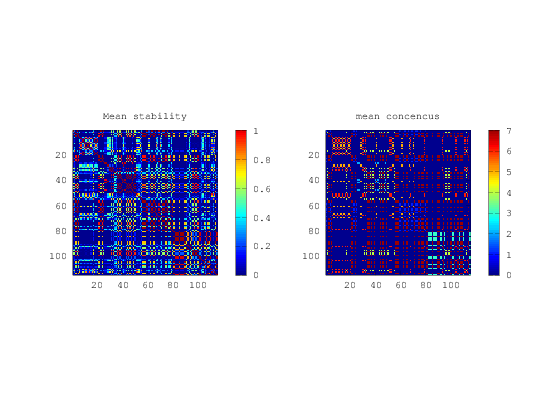

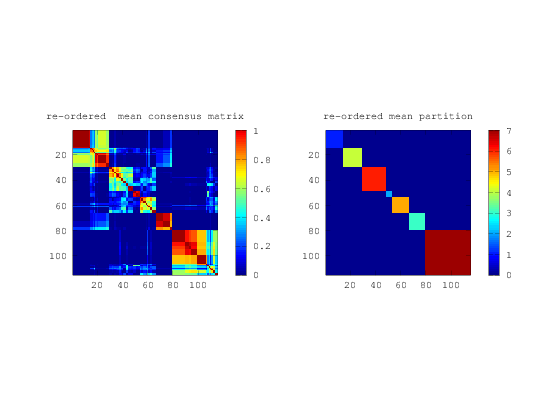

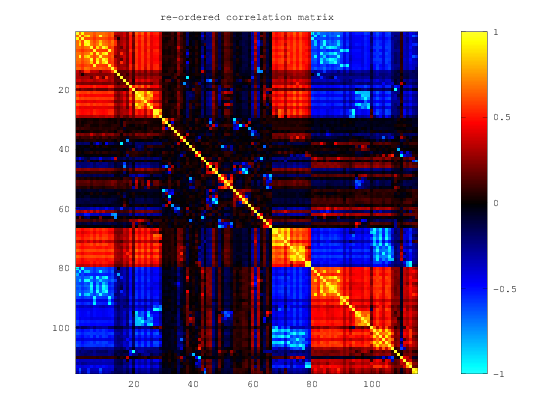

In [84]:
%%octave
subplot(1,2,1)
imagesc(stab), axis square, colormap(jet), colorbar, title('Mean stability')
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy
subplot(1,2,2)
niak_visu_part(part_consensus), axis square, colormap(jet),title('mean concencus') # visualize the consensus partition
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
figure
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab(order_consensus,order_consensus)), axis square,colorbar, title('re-ordered  mean consensus matrix')
# Show the re-ordered partition
subplot(1,2,2)
niak_visu_part(part_consensus(order_consensus)), axis square,colorbar,title('re-ordered mean partition')
# Re-order the correlation matrix
figure
subplot(1,1,1)
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar,title('re-ordered correlation matrix')

Let's have a look at the stability matrix:

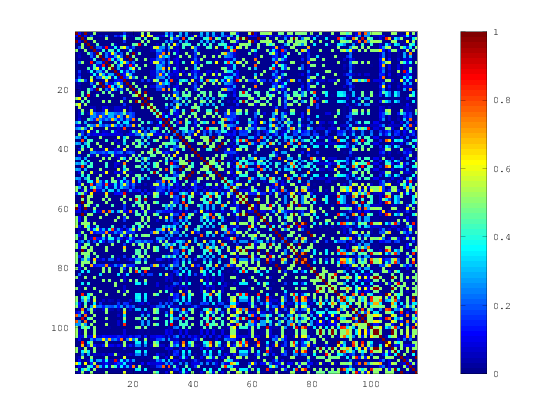

In [82]:
%octave imagesc(stab_m), axis square, colormap(jet), colorbar

In [78]:
%%octave -o nb_cluster
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab_m); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy

     Percentage done : 0 5 11 16 20 25 31 35 40 46 50 55 61 66 70 75 81 85 90 96 100 Done ! 

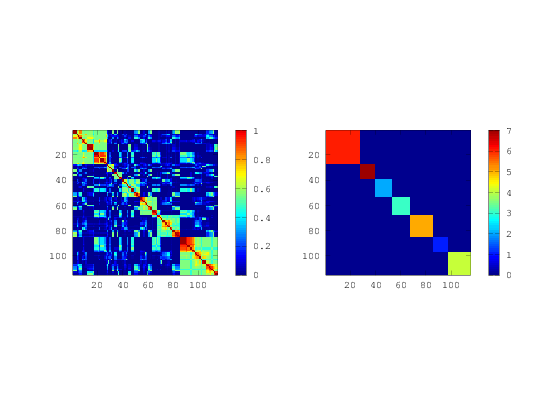

In [79]:
%%octave
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered consensus matrix')
imagesc(stab_m(order_consensus,order_consensus)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part_consensus(order_consensus)), axis square

In [80]:
#%octave niak_visu_dendrogram(hier_consensus)

ans =  1

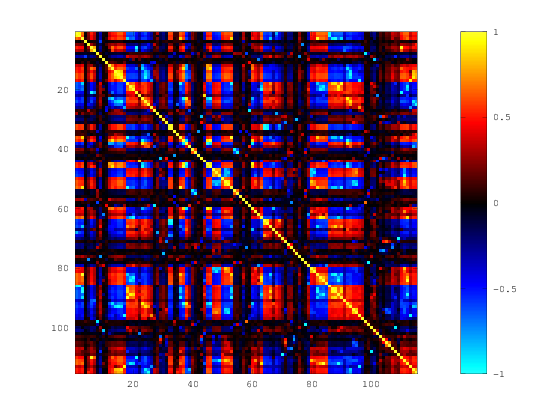

In [81]:
%%octave
# Re-order the correlation matrix
title('re-ordered correlation matrix')
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar

In [71]:
# push labels to octave
%octave_push LABELS_Y
%octave LABELS_Y = LABELS_Y';

In [72]:
%%octave
# calculate the mean cluster and save it
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
order_s =[];
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end

Cluster 1: 

     sub3_fear 

     sub1_match 

     sub3_match 

     sub2_contrast_relation_vs_match 

     sub4_contrast_mental_vs_rnd 

     sub2_places 

     sub4_body 

     sub5_faces 

     sub2_rf 

     sub1_lf 

     sub4_2bk 

     sub1_tools 

Cluster 2: 

     sub4_win 

     sub3_loss 

     sub5_contrast_win_vs_loss 

     sub4_rh 

     sub1_contrast_mental_vs_rnd 

     sub2_contrast_2bk_vs_0bk 

     sub3_body 

     sub4_rf 

     sub4_lh 

     sub4_lf 

     sub1_t 

     sub1_rf 

     sub2_lf 

     sub3_contrast_relation_vs_match 

Cluster 3: 

     sub5_win 

     sub4_loss 

     sub2_contrast_win_vs_loss 

     sub1_contrast_relation_vs_match 

     sub1_loss 

     sub4_faces 

     sub4_contrast_2bk_vs_0bk 

     sub3_lh 

     sub4_rnd 

     sub5_mental 

     sub1_story 

     sub4_story 

     sub2_match 

     sub1_contrast_2bk_vs_0bk 

Cluster 4: 

     sub1_win 

     sub1_contrast_win_vs_loss 

     sub2_relation 

     sub3_rnd 

     sub4_mental 

     sub3_rh 

     sub2_rh 

     sub5_rf 

     sub3_lf 

     sub2_loss 

     sub5_relation 

     sub3_t 

     sub4_places 

     sub5_lh 

     sub3_contrast_mental_vs_rnd 

     sub5_2bk 

     sub5_tools 

     sub5_0bk 

Cluster 5: 

     sub5_fear 

     sub2_story 

     sub4_t 

     sub2_lh 

     sub3_win 

     sub5_loss 

     sub5_rh 

     sub2_t 

     sub1_relation 

     sub3_0bk 

     sub3_contrast_win_vs_loss 

     sub2_rnd 

     sub3_rf 

     sub5_lf 

     sub4_match 

     sub2_contrast_mental_vs_rnd 

     sub1_mental 

     sub1_rnd 

Cluster 6: 

     sub1_fear 

     sub4_fear 

     sub5_match 

     sub3_relation 

     sub2_0bk 

     sub1_places 

     sub3_places 

     sub2_win 

     sub4_relation 

     sub5_rnd 

     sub3_2bk 

     sub3_contrast_2bk_vs_0bk 

     sub2_body 

     sub1_faces 

     sub2_faces 

     sub2_tools 

     sub2_2bk 

     sub5_contrast_relation_vs_match 

     sub5_contrast_mental_vs_rnd 

     sub3_mental 

     sub5_places 

     sub2_mental 

     sub5_body 

     sub4_0bk 

     sub3_tools 

     sub1_2bk 

     sub3_faces 

Cluster 7: 

     sub2_fear 

     sub1_rh 

     sub5_t 

     sub1_lh 

     sub3_story 

     sub5_story 

     sub4_contrast_win_vs_loss 

     sub1_0bk 

     sub4_contrast_relation_vs_match 

     sub1_body 

     sub5_contrast_2bk_vs_0bk 

     sub4_tools 

In [58]:
%%octave -o stack
#get subtype maps
# calculate the mean cluster and save it
stack = [];
part_consensus_order = part_consensus(order_consensus);
y_order = y_maps(:,order_consensus);
for ii = 1:nb_cluster
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
end

In [59]:
stack.shape

(59900, 7)

In [60]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0
print('NVoxels = {}'.format(np.sum(mask)))
print('Shape = {}'.format(mask.shape))

NVoxels = 59900
Shape = (53, 64, 52)


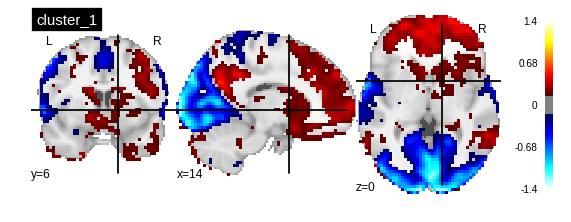

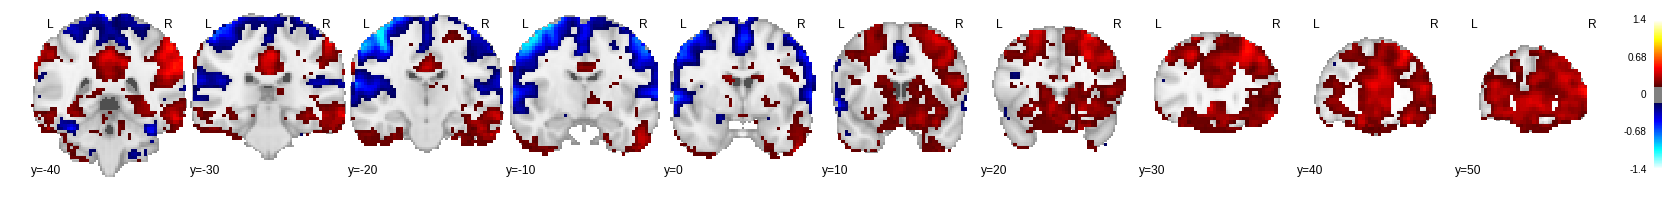

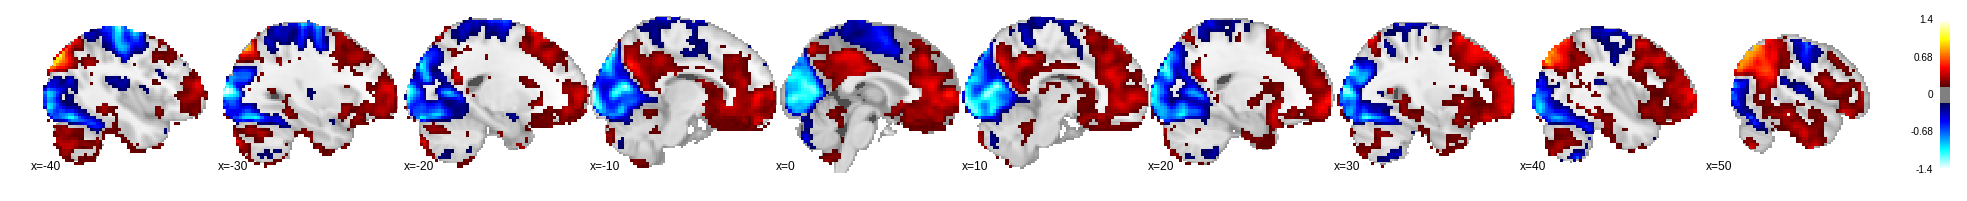

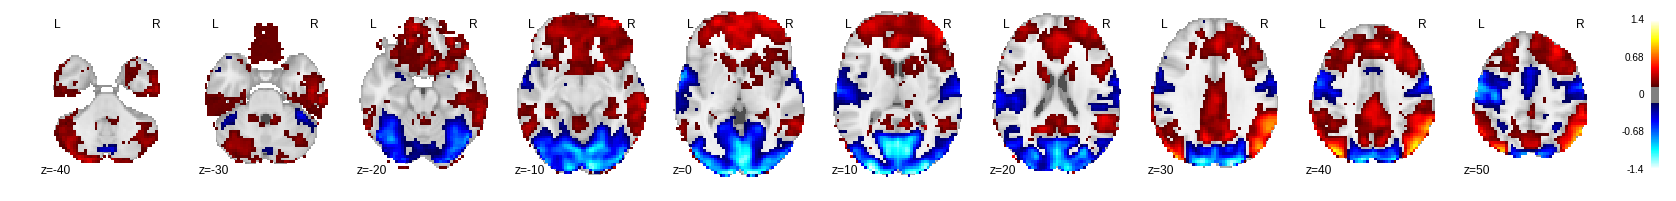

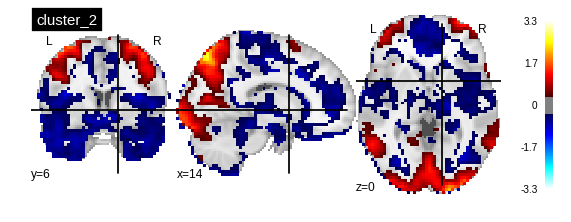

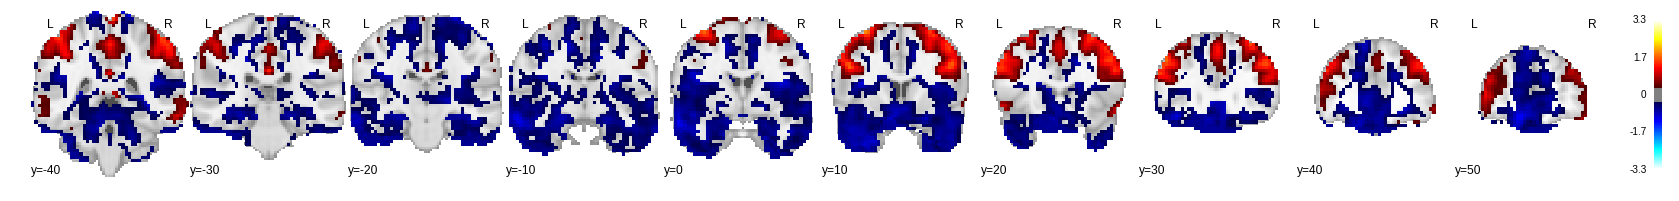

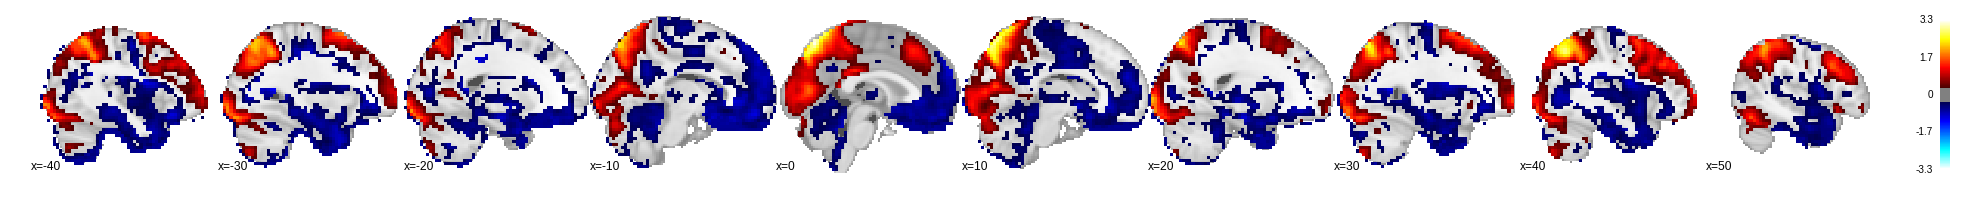

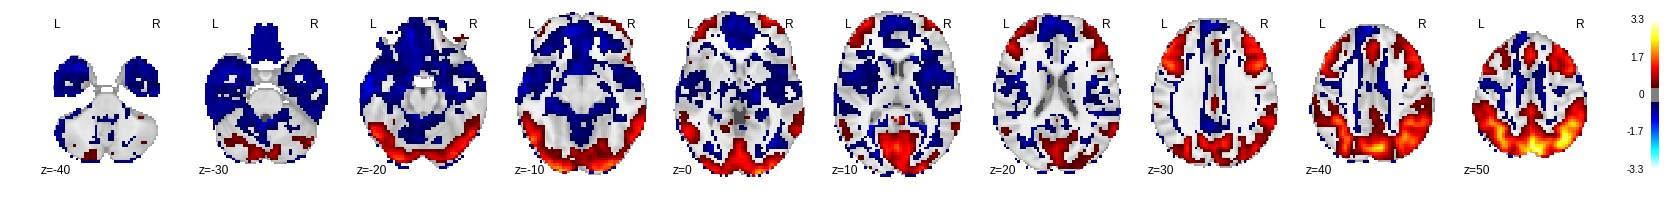

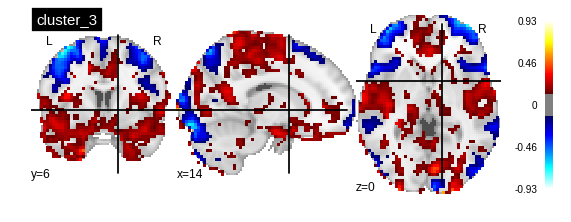

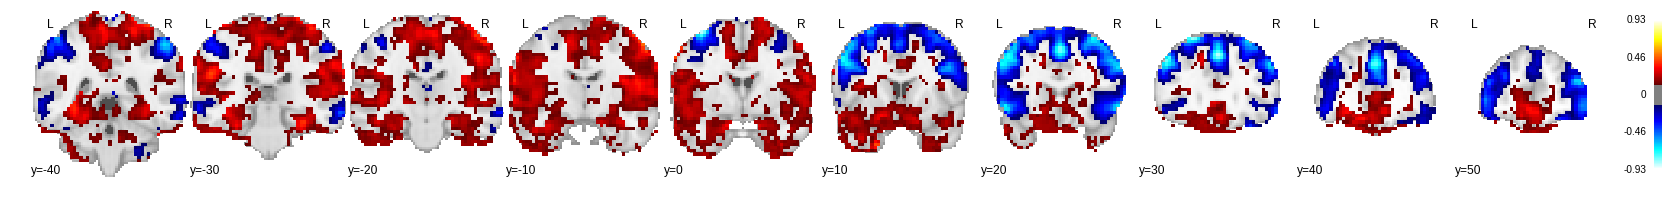

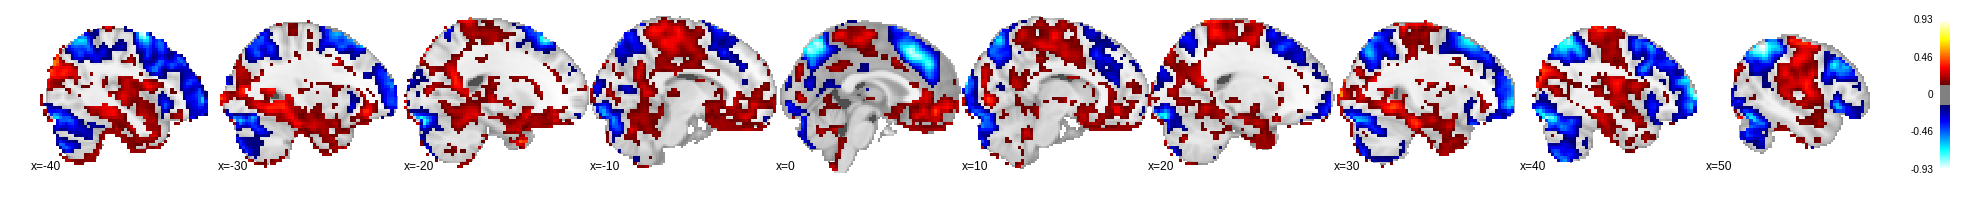

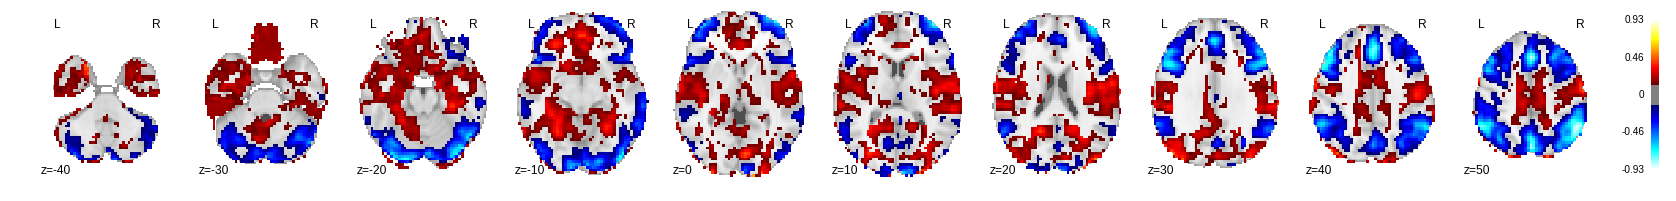

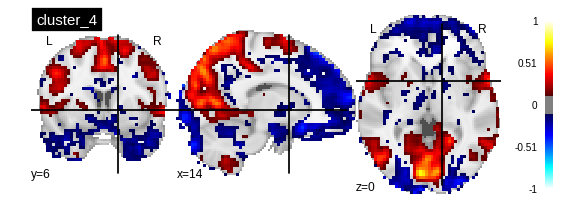

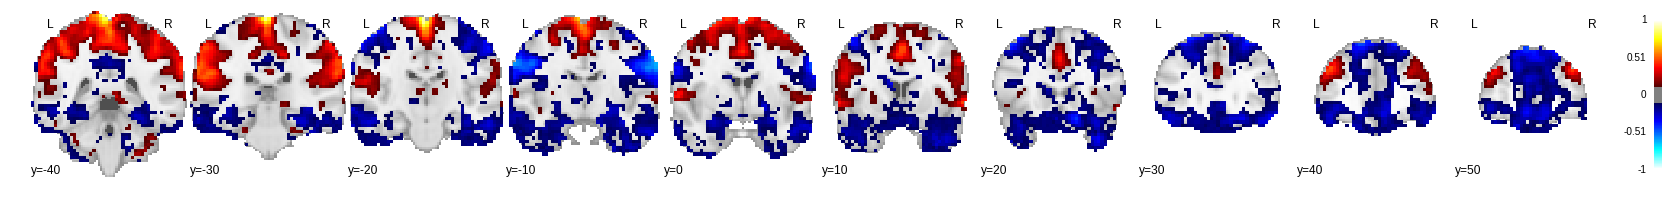

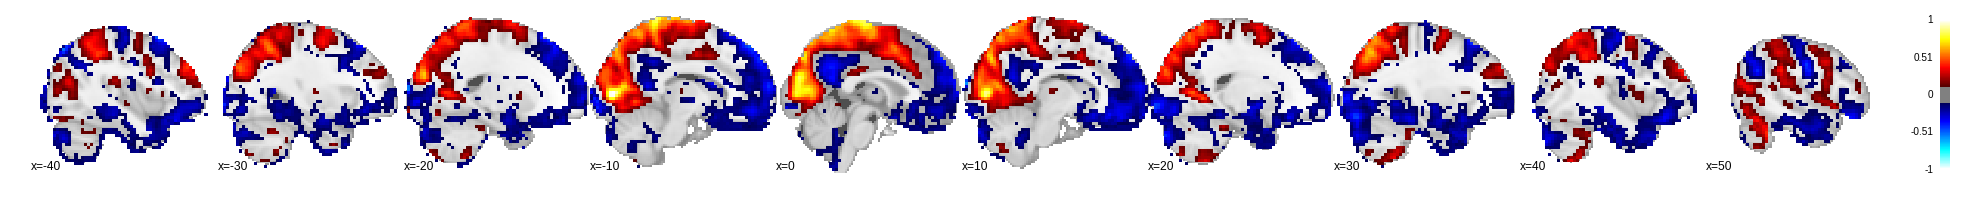

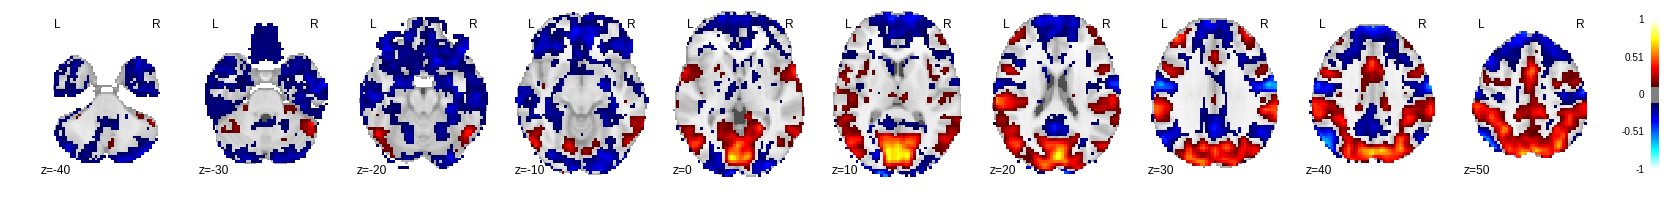

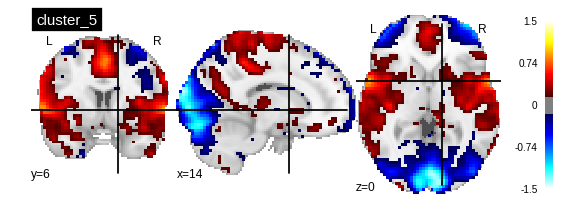

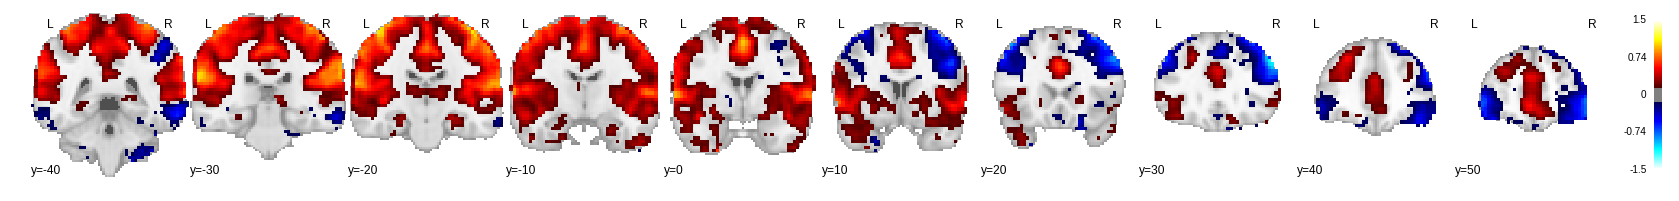

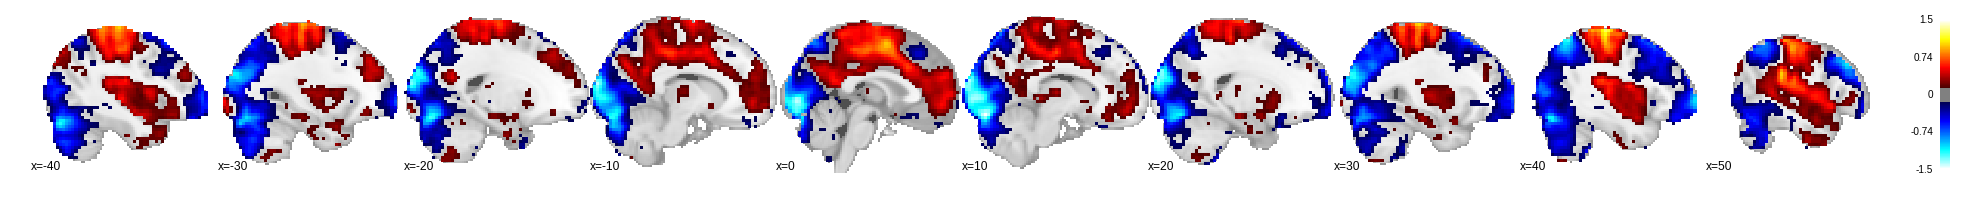

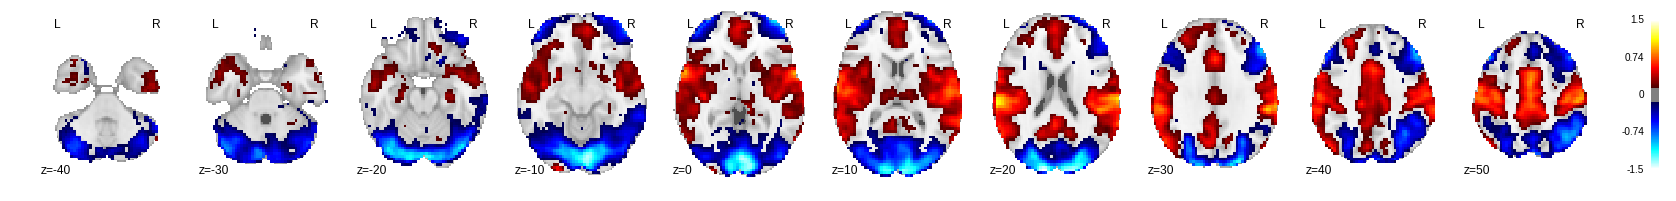

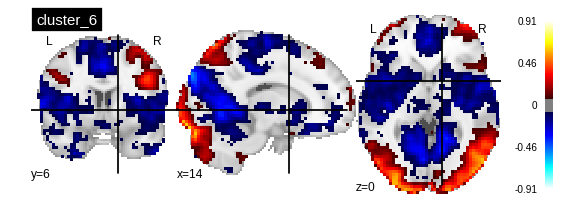

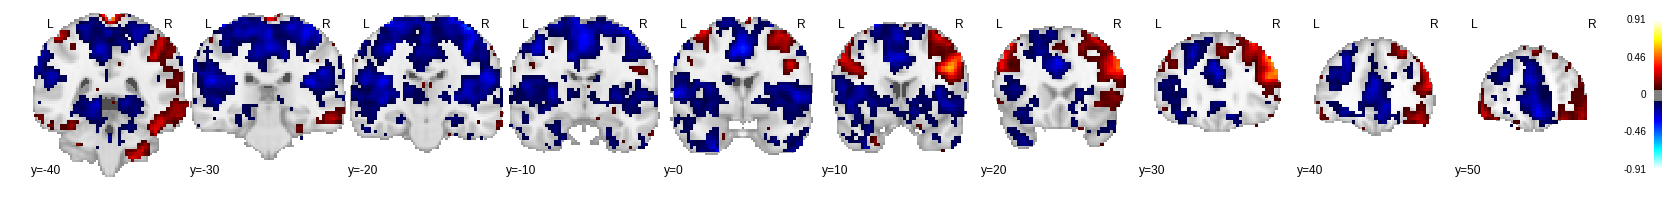

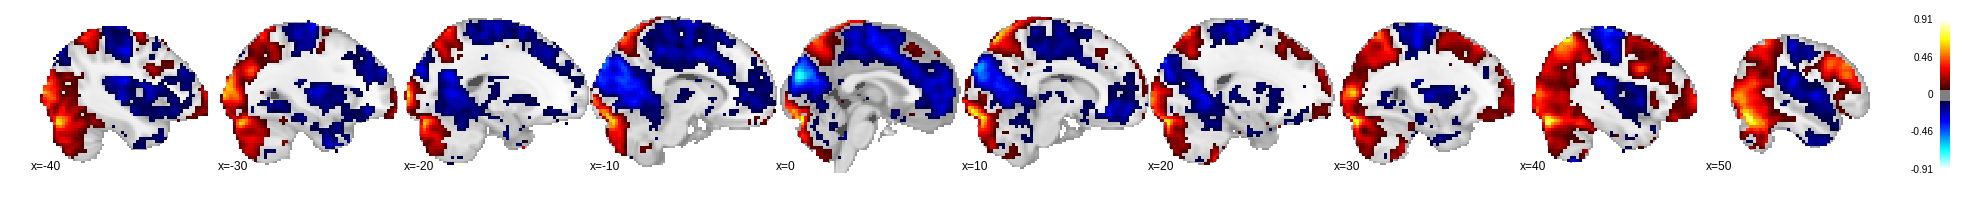

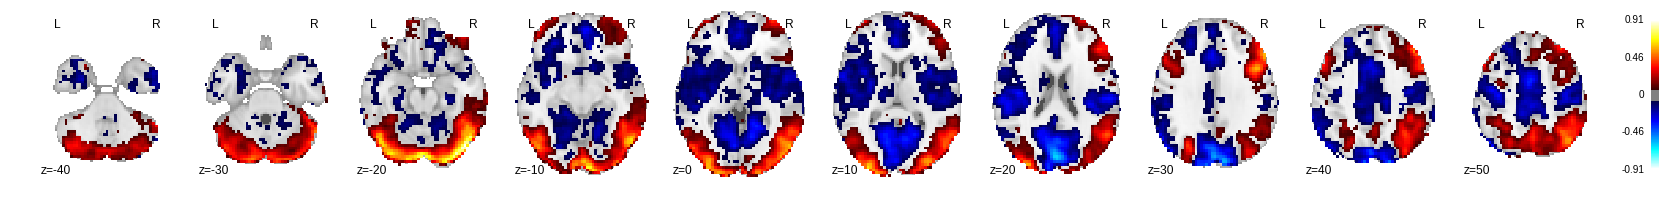

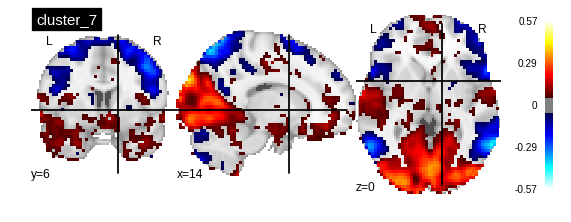

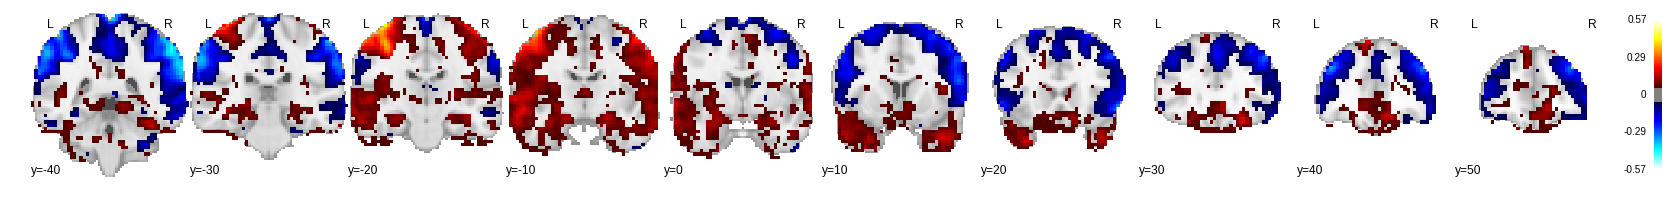

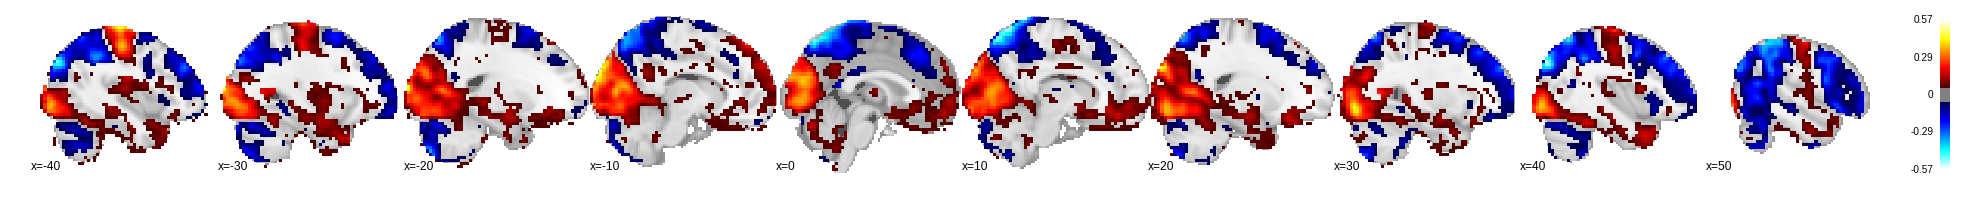

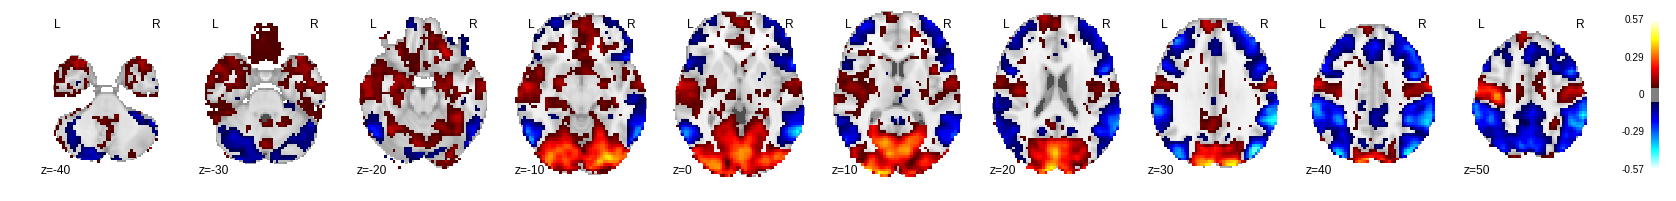

In [61]:
for cluster_num in range(int(nb_cluster)):
    sbt = stack[:,cluster_num]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    %octave_push mask sbt
    %octave vol = niak_tseries2vol(sbt,mask);
    %octave_pull vol
    sbt_img = nib.Nifti1Image(vol, affine=m_img.get_affine(), header=m_img.get_header())
    display = plotting.plot_stat_map(sbt_img,cut_coords=(14,6, 0),threshold= 'auto',
                                     title= "cluster_%s" % str(cluster_num+1))
    display = plotting.plot_stat_map(sbt_img, threshold= 'auto',
                                     display_mode='y',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='x',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='z',
                                     cut_coords= range(-40, 60, 10)
                                    )
